<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [8]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [9]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('storage_sample_stage4.h5', 'test_df',mode='r')

In [10]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d',
       'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5',
       'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4',
       'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3',
       'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2',
       'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [11]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [31]:
df_final_train.head()

,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,...,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
0,0,0.000000,0.000000,0.000000,11,6,15,8,0,0,...,1.983703e-06,1.545076e-13,8.108214e-13,1.719700e-14,-1.355344e-12,4.675296e-13,1.128588e-06,6.616661e-14,9.770900e-13,4.160009e-14
1,0,0.250000,0.236228,0.400000,7,8,5,5,5,2,...,1.817149e-15,4.900357e-16,1.488864e-15,7.493888e-15,-2.607466e-18,3.269773e-18,2.722918e-15,7.343201e-16,2.231744e-15,1.123464e-14
2,0,0.096774,0.026307,0.181568,20,17,21,13,2,3,...,7.483270e-09,1.010816e-11,1.483744e-11,2.242012e-12,-4.736288e-12,1.613720e-12,7.517345e-09,1.054761e-11,4.709001e-12,1.523742e-12
3,0,0.055556,0.047619,0.129099,4,21,4,15,2,1,...,8.005101e-12,9.319854e-15,3.637247e-14,5.070556e-16,-3.868634e-12,6.808609e-10,4.145904e-08,3.124601e-12,1.168078e-10,1.563176e-12
4,0,0.000000,0.000000,0.000000,1,2,1,0,0,0,...,4.300916e-13,1.431315e-15,6.755513e-14,7.800101e-18,-3.668679e-23,6.943767e-23,-1.895646e-23,-2.063655e-23,-3.377224e-22,1.362139e-22


In [13]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

Estimators =  10 Train Score 0.9166589584682269 test Score 0.9107742352524137
Estimators =  50 Train Score 0.9255901399623983 test Score 0.912958967896277
Estimators =  100 Train Score 0.9260323197292413 test Score 0.9196838347781744
Estimators =  250 Train Score 0.9245566764834889 test Score 0.9204458760701874
Estimators =  450 Train Score 0.9256257050933858 test Score 0.9213511736890094


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

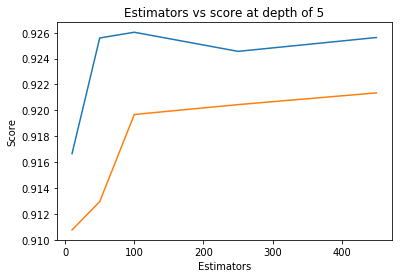

In [14]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.8906561474934344 test Score 0.865932727035377
depth =  9 Train Score 0.9551662495530925 test Score 0.9246653919694072
depth =  11 Train Score 0.9624994913116022 test Score 0.9262638507837259
depth =  15 Train Score 0.9643945860260944 test Score 0.9264133693364234
depth =  20 Train Score 0.965000354965974 test Score 0.9241576023329573
depth =  35 Train Score 0.9650884453099643 test Score 0.9238954626713204
depth =  50 Train Score 0.9650884453099643 test Score 0.9238954626713204
depth =  70 Train Score 0.9650884453099643 test Score 0.9238954626713204
depth =  130 Train Score 0.9650884453099643 test Score 0.9238954626713204


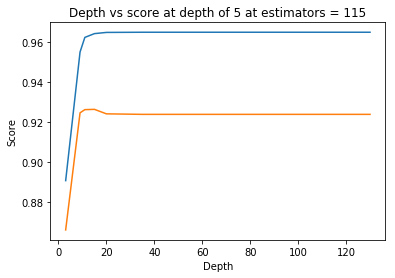

In [15]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [16]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
#print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.96307145 0.96274034 0.96053943 0.96236161 0.96450201]


In [17]:
print(rf_random.cv_results_)

{'split8_test_score': array([0.96216436, 0.96257012, 0.96013052, 0.96189894, 0.96386033]), 'std_score_time': array([0.00184693, 0.00015177, 0.00015997, 0.00021206, 0.00038525]), 'param_max_depth': masked_array(data=[14, 12, 11, 13, 14],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'split0_test_score': array([0.95921066, 0.96008126, 0.95722849, 0.95900142, 0.96202275]), 'split3_test_score': array([0.96383584, 0.96306069, 0.96063473, 0.96172977, 0.96497106]), 'std_fit_time': array([0.31603506, 0.12260708, 0.08819669, 0.03834582, 0.13443847]), 'mean_fit_time': array([9.04617162, 8.42024336, 7.80498815, 8.23532348, 9.69111624]), 'split2_test_score': array([0.96217975, 0.96369168, 0.95907147, 0.96357179, 0.96678145]), 'mean_score_time': array([0.10955036, 0.10863428, 0.10874414, 0.10882597, 0.10869744]), 'param_min_samples_split': masked_array(data=[125, 138, 179, 165, 111],
             mask=[False, False, False, False, False],
  

In [18]:
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=14, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=28, min_samples_split=111,
                       min_weight_fraction_leaf=0.0, n_estimators=121,
                       n_jobs=-1, oob_score=False, random_state=25, verbose=0,
                       warm_start=False)


In [19]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [20]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [21]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9654108476778174
Test f1 score 0.9276322776609528


In [22]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


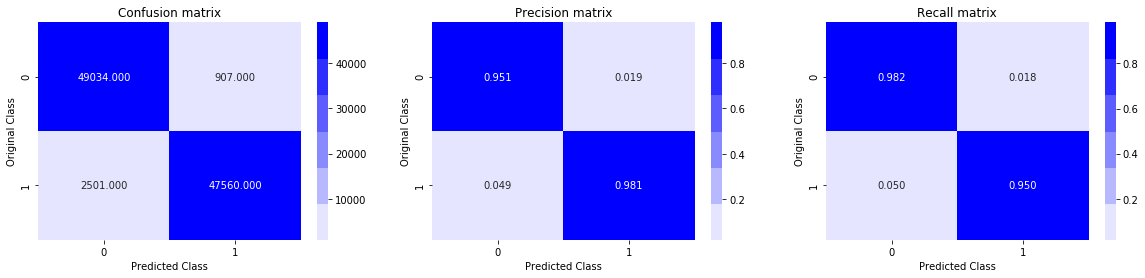

Test confusion_matrix


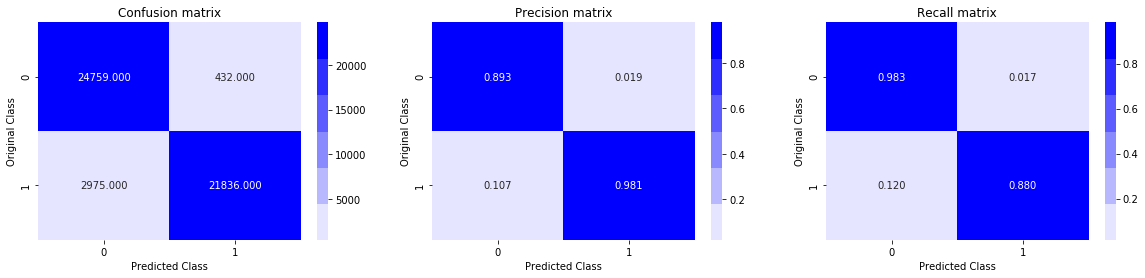

In [23]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

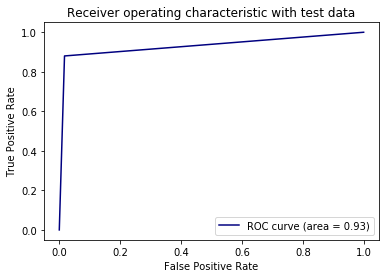

In [24]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

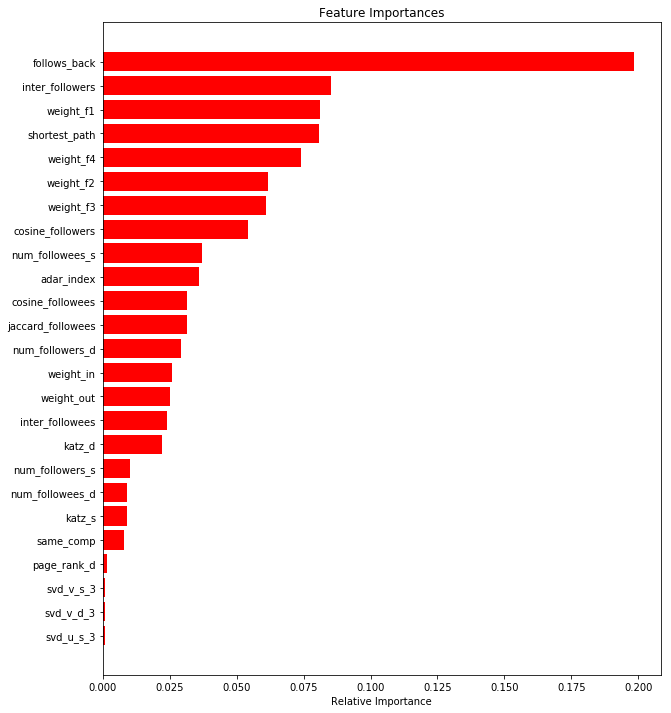

In [25]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Assignments:

1. Add another feature called  Preferential Attachment  with followers and followees data of vertex. you can check about Preferential Attachment in below link
http://be.amazd.com/link-prediction/ <br>
2. Add  feature called svd_dot. you can calculate svd_dot as Dot product between sourse node svd and destination node svd features.  you can read about this in below pdf 
https://storage.googleapis.com/kaggle-forum-message-attachments/2594/supervised_link_prediction.pdf<br>
3. Tune hyperparameters for XG boost with all these features and check the error metric.

## set_1 

In [94]:
t=pd.DataFrame(df_final_train)

In [95]:
w=t['num_followers_s']
r=t['num_followers_d']

In [96]:
p=w.shape

In [97]:
pre=[]
for i in range(0,p[0]):
    pre.append(w[i]*r[i])
    

In [104]:
print(pre[0:10])

[66, 56, 340, 84, 2, 132, 63, 0, 442, 16]


In [102]:
df_final_train['Preferential Attachment']=pre

In [103]:
df_final_train.columns

Index(['jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d',
       'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5',
       'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4',
       'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3',
       'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2',
       'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'Preferential Attachment'],
      dtype='object')

In [105]:
w=df_final_test['num_followers_s']
r=df_final_test['num_followers_d']

In [107]:
p=w.shape

In [108]:
pre=[]
for i in range(0,p[0]):
    pre.append(w[i]*r[i])

In [109]:
print(pre[0:10])

[84, 27, 24, 18, 18, 99, 288, 75, 6, 45]


In [110]:
df_final_test['Preferential Attachment']=pre

In [111]:
# normalize the given data as to make thenm on comman scale

from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

'''encode numerical feature '''
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.

normalizer.fit(df_final_train['Preferential Attachment'].values.reshape(-1,1)) # use code from sample

X_train_ac_norm = normalizer.transform(df_final_train['Preferential Attachment'].values.reshape(-1,1))

X_test_ac_norm = normalizer.transform(df_final_test['Preferential Attachment'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_ac_norm.shape, y_train.shape)

print(X_test_ac_norm.shape, y_test.shape)

print("="*100) 

After vectorizations
(100002, 1) (100002,)
(50002, 1) (50002,)


In [112]:
df_final_train['Preferential Attachment']=X_train_ac_norm
df_final_test['Preferential Attachment']=X_test_ac_norm


In [115]:
df_final_test.columns

Index(['jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d',
       'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5',
       'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4',
       'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3',
       'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2',
       'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'Preferential Attachment'],
      dtype='object')

## task_2

In [138]:
a=t['svd_v_s_1']
b=t['svd_v_s_2']
c=t['svd_v_s_3']
d=t['svd_v_s_4']
e=t['svd_v_s_5']
f=t['svd_v_s_6']
g=t['svd_u_s_1']
h=t['svd_u_s_2']
i=t['svd_u_s_3']
j=t['svd_u_s_4']
k=t['svd_u_s_5']
l=t['svd_u_s_6']


In [139]:
from scipy.sparse import vstack
nwe=np.vstack((a,b,c,d,e,f,i,j,k,l,g,h)).T

In [140]:
p=nwe.shape

In [141]:
p[0]

100002

In [143]:
# svd_d
nwe_2=np.vstack((t['svd_v_d_1'],t['svd_v_d_2'],t['svd_v_d_3'],t['svd_v_d_4'],t['svd_v_d_5'],t['svd_v_d_6'],t['svd_u_d_1'],t['svd_u_d_2'],t['svd_u_d_3'],t['svd_u_d_4'],t['svd_u_d_5'],t['svd_u_d_6'])).T

In [144]:
nwe_2.shape

(100002, 12)

In [145]:
nwe[0]

array([-7.21566139e-13,  3.92581658e-13,  1.98370281e-06,  1.54507573e-13,
        8.10821415e-13,  1.71970040e-14,  1.04304248e-05,  6.67803265e-13,
        2.45109502e-13,  3.58494474e-12, -1.66629360e-13,  4.61379396e-13])

In [146]:
svdot=[]
for i in range(0,p[0]):
    svdot.append(np.dot(nwe[i],nwe_2[i]))

In [147]:
print(len(svdot))

100002


In [148]:
df_final_train['svd_dot']=svdot

In [149]:
nwe=np.vstack((df_final_test['svd_v_d_1'],df_final_test['svd_v_d_2'],df_final_test['svd_v_d_3'],df_final_test['svd_v_d_4'],df_final_test['svd_v_d_5'],df_final_test['svd_v_d_6'],df_final_test['svd_u_d_1'],df_final_test['svd_u_d_2'],df_final_test['svd_u_d_3'],df_final_test['svd_u_d_4'],df_final_test['svd_u_d_5'],df_final_test['svd_u_d_6'])).T

In [150]:
nwe_2=np.vstack((df_final_test['svd_v_s_1'],df_final_test['svd_v_s_2'],df_final_test['svd_v_s_3'],df_final_test['svd_v_s_4'],df_final_test['svd_v_s_5'],df_final_test['svd_v_s_6'],df_final_test['svd_u_s_1'],df_final_test['svd_u_s_2'],df_final_test['svd_u_s_3'],df_final_test['svd_u_s_4'],df_final_test['svd_u_s_5'],df_final_test['svd_u_s_6'])).T

In [152]:
p=nwe.shape

In [153]:
svdot=[]
for i in range(0,p[0]):
    svdot.append(np.dot(nwe[i],nwe_2[i]))

In [154]:
df_final_test['svd_dot']=svdot

## task_3

In [157]:
# parameter tunning xgboost

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

xgb_model = xgb.XGBClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(xgb_model, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
#print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.98108184 0.98138645 0.98082843 0.98093917 0.9810614 ]


In [158]:
# printbest estimater
print(rf_random.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=12,
              min_child_weight=1, min_samples_leaf=33, min_samples_split=138,
              missing=None, n_estimators=109, n_jobs=-1, nthread=None,
              objective='binary:logistic', random_state=25, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)


In [160]:
# test phase
xg=xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=12,
              min_child_weight=1, min_samples_leaf=33, min_samples_split=138,
              missing=None, n_estimators=109, n_jobs=-1, nthread=None,
              objective='binary:logistic', random_state=25, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [162]:
# predicting
xg.fit(df_final_train,y_train)
y_train_pred = xg.predict(df_final_train)
y_test_pred = xg.predict(df_final_test)

In [163]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9973775348827898
Test f1 score 0.9276552077988712


In [164]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


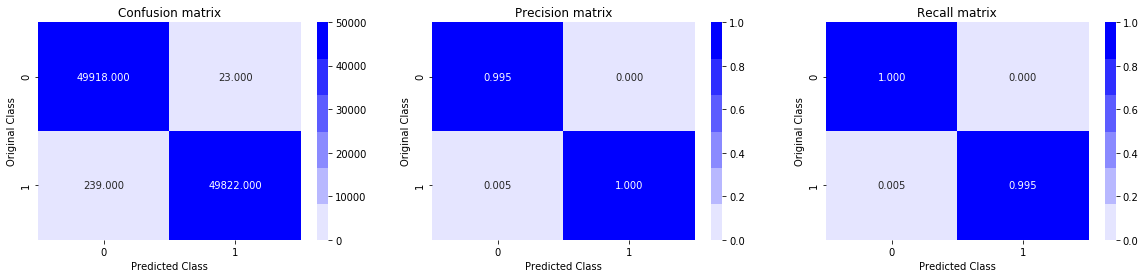

Test confusion_matrix


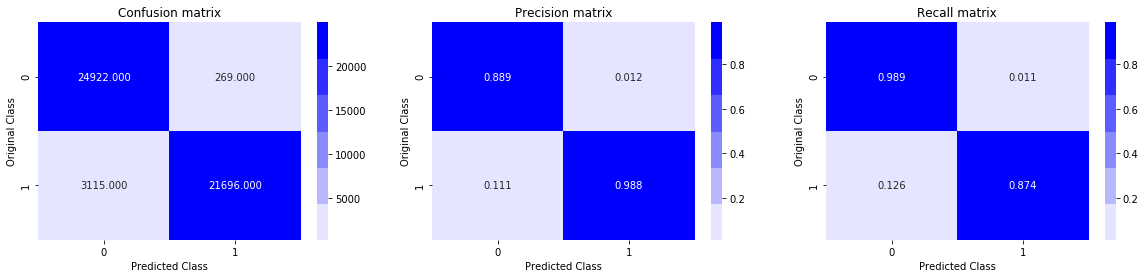

In [165]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

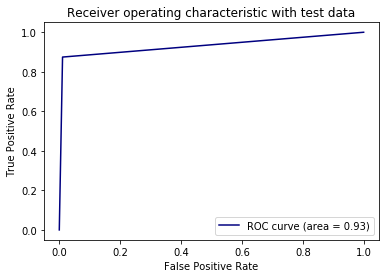

In [166]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

## conclusion

In [2]:
# Please compare all your models using Prettytable library

from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["model", "train_f1_score", "test_f1_score"]

In [3]:
x.add_row(['random_forest',0.9654108476778174,0.9276322776609528])
x.add_row(['XGBOOST',0.9973775348827898,0.9276552077988712])

In [4]:
print(x)

+---------------+--------------------+--------------------+
|     model     |   train_f1_score   |   test_f1_score    |
+---------------+--------------------+--------------------+
| random_forest | 0.9654108476778174 | 0.9276322776609528 |
|    XGBOOST    | 0.9973775348827898 | 0.9276552077988712 |
+---------------+--------------------+--------------------+
